In [1]:
# window[40] -> 1
# given 100 point sines with random freq and phase
# with a sliding input window of N=40, predict the next point

# working, but why accuracy 0?

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

# might need to comment this out if you don't have a GPU
# perhaps unecessary in general, but I haven't found a way to make it work!
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

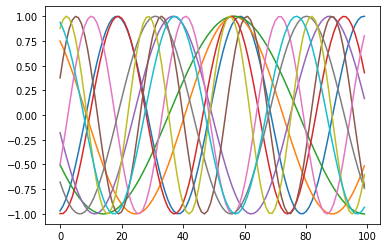

In [180]:
def gen_random_sine(n_points=100):
    frequency = random.random() * 3 + 1
    phase_offset = random.random() * 2 * np.pi
    xs = np.linspace(0.0, 2*np.pi, n_points)
    ys = np.sin(xs*frequency+phase_offset)
    return ys

# have a look at some random sine waves
for _ in range(10):
    ys = gen_random_sine()
    plt.plot(ys)

In [206]:
# gen train / test data

def sliding_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

ws = []
for i in range(100):
    ws.extend(sliding_window(gen_random_sine(), 41))
    if i == 0:
        print(len(ws))
ws = np.array(ws)

# keep the first 40 points [0..39] for the input window and last [40] to be predicted
xs, ys = zip(*[(w[:40], w[40]) for w in ws])
xs, ys = np.array(xs), np.array(ys)


x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33)
# x_train = x_train.reshape(x_train.shape + (1, ))
# x_test = x_test.reshape(x_test.shape + (1, ))

x_train.shape, y_train.shape, x_test.shape, y_test.shape


60


((4020, 40), (4020,), (1980, 40), (1980,))

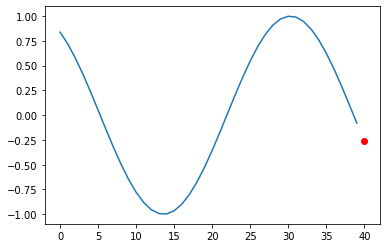

In [207]:
# examine one x,y pair
plt.plot(x_train[0])
plt.scatter([40], [y_train[0]], c='r')

In [183]:
def plot_training_history(history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()
    
    loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
    print(f'Test loss: {loss:.3}')

    print(f'Test accuracy: {accuracy:.3}')

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 160)               6560      
_________________________________________________________________
dense_75 (Dense)             (None, 80)                12880     
_________________________________________________________________
dropout_15 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_77 (Dense)             (None, 20)                820       
_________________________________________________________________
flatten_15 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)               

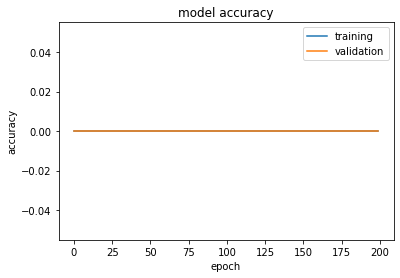

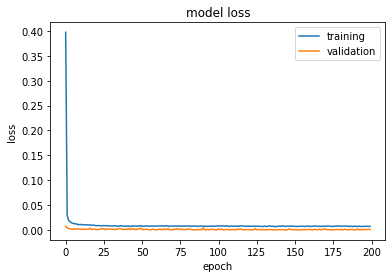

Test loss: 0.000541
Test accuracy: 0.0


In [250]:
# model and train
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('{:d}/{:.4f}/{:.4f}/{:.4f}/{:.4f} '.format(epoch, logs['loss'], logs['accuracy'], 
            logs['val_loss'], logs['val_accuracy']), end='')


test_data = x_test
test_labels = y_test
model = Sequential()
model.add(Input(shape=(40,)))
model.add(Dense(160, activation='linear'))
model.add(Dense(80, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(40, activation='linear'))
model.add(Dense(20, activation='linear'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, shuffle=True, batch_size=64, epochs=200, verbose=0, validation_split=.2, callbacks=[MyCallback()])
plot_training_history(history, model)

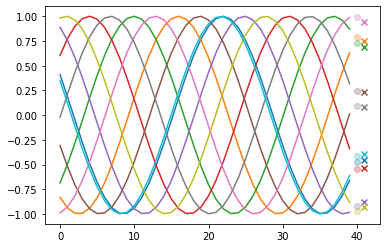

In [236]:
# generate a random sine and compute windows
# check expected vs actual for predicted point beyond window
tws = sliding_window(gen_random_sine(), 41)
xs, ys = zip(*[(w[:40], w[40]) for w in tws])
xs, ys = np.array(xs), np.array(ys)

s = 6
for x in xs[0:60:s]:
    plt.plot(x)

# plot expected predictions    
for index, y in enumerate(ys[0:60:s]):
    plt.scatter([40], [y], alpha=0.3)

# plot actuals
yhat = model.predict(xs[0:60:s])
for yh in yhat:
    plt.scatter([41], [yh], marker='x')

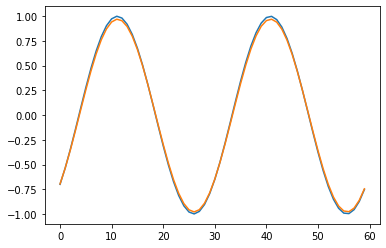

In [249]:
# given a series of input window from 1 sine curve, we should see sine as output
tws = sliding_window(gen_random_sine(), 41)
xs, ys = zip(*[(w[:40], w[40]) for w in tws])
xs, ys = np.array(xs), np.array(ys)

yhat = model.predict(xs)
plt.plot(ys)
_ = plt.plot(yhat.reshape(-1,))